In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!git clone https://github.com/NidhiAI/End-to-End-Gender_Detection_From_Audio

Cloning into 'End-to-End-Gender_Detection_From_Audio'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 67 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (67/67), 2.37 MiB | 4.87 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
#import csv
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras

from keras import layers

#from sklearn.preprocessing import LabelEncoder#, StandardScalerimport keras
#from keras.models import Sequentialimport #, warnings
#warnings.filterwarnings('ignore')

Creating a header for our CSV file.

In [3]:
# create headers 
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [4]:
import csv
csvFilePath = "/kaggle/working/End-to-End-Gender_Detection_From_Audio/generatedFeatures/"
file = open(csvFilePath+'librosa.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
#genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
genres = 'male female'.split()
for g in genres:
    for filename in os.listdir(f'/kaggle/working/End-to-End-Gender_Detection_From_Audio/librosa_mp3/{g}'):
        songname = f'/kaggle/working/End-to-End-Gender_Detection_From_Audio/librosa_mp3/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        #rmse = librosa.feature.rmse(y=y)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open(csvFilePath+'librosa.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

Data preprocessing: It involves loading CSV data, label encoding, feature scaling and data split into training and test set.

In [5]:
data = pd.read_csv('/kaggle/working/End-to-End-Gender_Detection_From_Audio/generatedFeatures/librosa.csv')
data.head() # Display 5 wav files features 

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,Naseeruddin_Shah-1.wav,0.376094,0.030631,931.741125,1241.241272,1766.527915,0.041611,-377.436279,167.818512,13.445023,...,-4.874533,3.015424,-7.811646,3.535903,1.873103,-0.084137,-1.040924,0.396692,0.471761,male
1,Irfan_khan-1.wav,0.420867,0.047094,1476.381871,1553.611007,2938.653826,0.080629,-321.187073,134.928162,2.005424,...,0.484080,5.566564,-6.452596,13.930090,-0.897301,-2.380837,1.235056,-0.334520,-3.501905,male
2,John_Abraham-1.wav,0.318019,0.087968,1218.930822,1119.681450,2237.779326,0.080105,-262.463593,176.505585,-44.920864,...,-19.281878,-5.891163,-13.045155,-9.814127,6.345486,-18.736895,-1.800199,-4.951712,-12.666855,male
3,Ajay_Devgan-1.wav,0.454327,0.058352,967.308983,1188.780388,1769.374486,0.048485,-281.642059,176.901978,4.768245,...,0.930168,5.092219,-7.643029,6.893967,0.913580,0.428194,-6.172984,-0.538486,-0.793509,male
4,Akshay_Kumar-1.wav,0.326106,0.061417,1271.315256,1436.092679,2263.097426,0.059420,-270.419312,142.378433,-19.196342,...,-7.392804,1.946873,-8.498398,-3.925524,-3.500736,-3.645290,-8.469566,-2.656865,-5.932680,male


In [6]:
data.label.unique()

array(['male', 'female'], dtype=object)

In [7]:
data.label.value_counts()

male      8
female    6
Name: label, dtype: int64

In [9]:
# Dropping unneccesary columns 'filename'
data = data.drop(['filename'],axis=1)#Encoding the Labels

KeyError: "['filename'] not found in axis"

<AxesSubplot:xlabel='label', ylabel='count'>

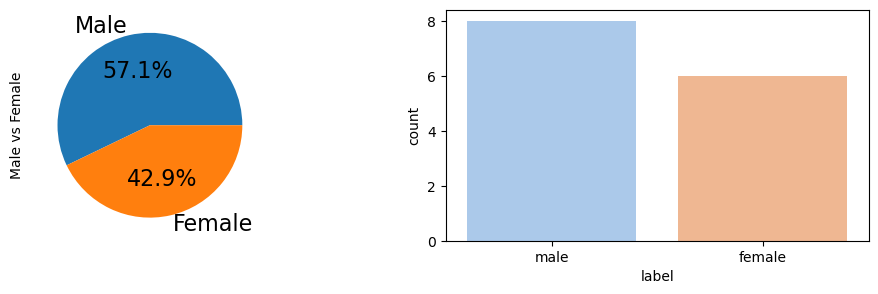

In [10]:
import seaborn as sns
plt.figure(figsize=(12, 3))

# left side graph
plt.subplot(1, 2, 1)
data.label.value_counts().plot(kind="pie",
                                           fontsize=16,
                                           labels=["Male", "Female"],
                                           ylabel="Male vs Female",
                                           autopct='%1.1f%%');
#plt.show()

# right side graph
plt.subplot(1, 2, 2)
sns.countplot(x="label",data=data, palette="pastel")

<AxesSubplot:>

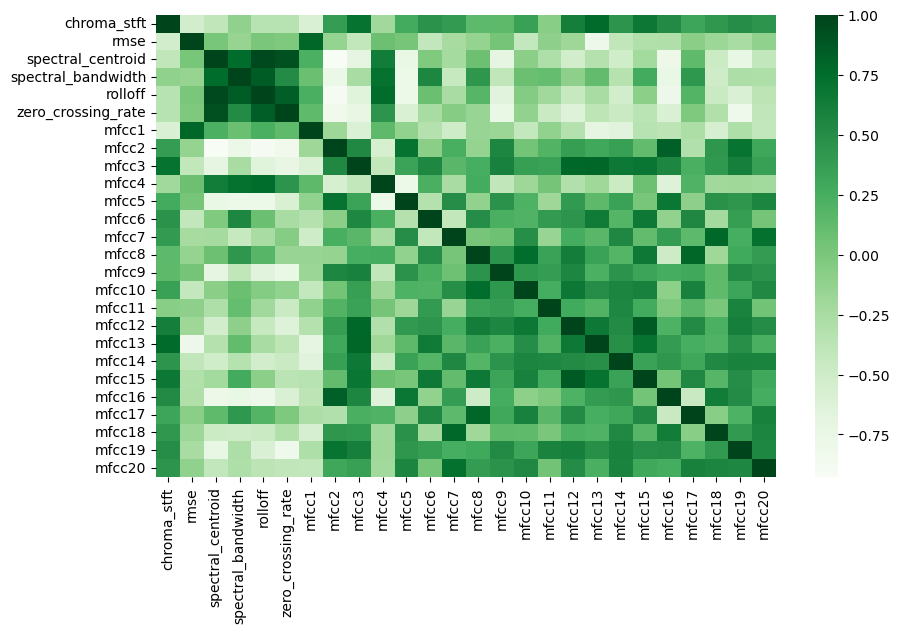

In [11]:
# check corerelation

plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),cmap='Greens',annot=False)

In [12]:
# now we will convert these 2 values in 0/1 
# male to 0, female to 1
data.label.replace(['male', 'female'],[0,1], inplace=True)

In [13]:
data.sample(2)

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
12,0.313835,0.029665,1476.734087,1616.437884,2869.433899,0.077096,-345.100769,139.181213,-15.589102,35.254250,...,-6.587690,0.170951,-5.476741,3.734800,-14.333503,2.436498,-5.962543,-1.555124,-5.172522,1
13,0.308318,0.068557,2260.609699,1701.551742,4104.999777,0.128914,-240.904785,100.114090,-62.172226,48.937523,...,-14.128423,-5.453281,-10.452946,-2.104902,-19.079119,-1.371553,-10.431274,-5.563672,-10.690256,1


x and y split

In [14]:
# Divive data into x(Independent variables) and y (Target/Dependent variable) 
x = data.drop("label", axis= 1)
y = data["label"]

In [15]:
# Print x 
print(x.shape)
x.head(2)

(14, 26)


,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.376094,0.030631,931.741125,1241.241272,1766.527915,0.041611,-377.436279,167.818512,13.445023,28.169819,...,-4.537297,-4.874533,3.015424,-7.811646,3.535903,1.873103,-0.084137,-1.040924,0.396692,0.471761
1,0.420867,0.047094,1476.381871,1553.611007,2938.653826,0.080629,-321.187073,134.928162,2.005424,30.947512,...,-2.081279,0.484080,5.566564,-6.452596,13.930090,-0.897301,-2.380837,1.235056,-0.334520,-3.501905


In [16]:
# Print y 
print(y.shape)
y.head(2)

(14,)


0    0
1    0
Name: label, dtype: int64

In [17]:
#Separate out objects and numeric columns in x  
cat_cols = x.columns[x.dtypes == 'object']
num_cols = x.columns[(x.dtypes == 'float64') | (x.dtypes == 'int64')]
# num_cols1=list(x.select_dtypes(exclude='object').columns) # can do this way also 

In [18]:
cat_cols 

# no categorical columns in x , so we do not need to apply onehot or get_dummies 

Index([], dtype='object')

In [19]:
# Now we will scale numeric columns
num_cols


Index(['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20'],
      dtype='object')

Standardisation

In [20]:
#applying scalar to all numeric columns 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#x[num_cols]=scaler.fit_transform(x[num_cols]) # no categorical columns, so can go with below 
x=scaler.fit_transform(x)

Train Test split

In [21]:
#Sample for training and testing the model
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.4, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8, 26), (6, 26), (8,), (6,))

In [22]:
##Modeling - AIML
#from genetic_selection import GeneticSelectionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB 

#Evaluation
from sklearn import metrics

# confusion matrix
import sklearn.metrics

Train models

In [23]:
#Build base models
lr = LogisticRegression(random_state=0).fit(X_train, Y_train)
rf = RandomForestClassifier(n_estimators = 7).fit(X_train, Y_train)
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train)
svc = SVC().fit(X_train, Y_train)
#nb = ComplementNB().fit(X_train, Y_train) # can not run this with negative values in data
nb = GaussianNB().fit(X_train, Y_train)

Predict on Train dataset

In [24]:
# Prediction on Train data set 
lr_pred = lr.predict(X_train)
rf_pred = rf.predict(X_train)
knn_pred = knn.predict(X_train)
svc_pred = svc.predict(X_train)
nb_pred = nb.predict(X_train)

lr_train_score_1 = 100*metrics.accuracy_score(Y_train, lr_pred)
rf_train_score_1 = 100*metrics.accuracy_score(Y_train, rf_pred)
knn_train_score_1 = 100*metrics.accuracy_score(Y_train, knn_pred)
svc_train_score_1 = 100*metrics.accuracy_score(Y_train, svc_pred)
nb_train_score_1 = 100*metrics.accuracy_score(Y_train, nb_pred)


print("Train Accuracy score of LR = ",lr_train_score_1)
print("Train Accuracy score of RF = ",rf_train_score_1)
print("Train Accuracy score of KNN = ",knn_train_score_1)
print("Train Accuracy score of SVC = ",svc_train_score_1)
print("Train Accuracy score of NB = ",nb_train_score_1)

Train Accuracy score of LR =  100.0
Train Accuracy score of RF =  100.0
Train Accuracy score of KNN =  100.0
Train Accuracy score of SVC =  100.0
Train Accuracy score of NB =  100.0


Predict on Test dataset

In [25]:
# Prediction on Test data set 
lr_pred_test = lr.predict(X_test)
rf_pred_test = rf.predict(X_test)
knn_pred_test = knn.predict(X_test)
svc_pred_test = svc.predict(X_test)
nb_pred_test = nb.predict(X_test)



In [26]:
lr_test_score_1 = 100*metrics.accuracy_score(Y_test, lr_pred_test)
rf_test_score_1 = 100*metrics.accuracy_score(Y_test, rf_pred_test)
knn_test_score_1 = 100*metrics.accuracy_score(Y_test, knn_pred_test)
svc_test_score_1 = 100*metrics.accuracy_score(Y_test, svc_pred_test)
nb_test_score_1 = 100*metrics.accuracy_score(Y_test, nb_pred_test)

print("Test Accuracy score of LR = ",lr_test_score_1)
print("Test Accuracy score of RF = ",rf_test_score_1)
print("Test Accuracy score of KNN = ",knn_test_score_1)
print("Test Accuracy score of SVC = ",svc_test_score_1)
print("Test Accuracy score of NB = ",nb_test_score_1)

Test Accuracy score of LR =  50.0
Test Accuracy score of RF =  83.33333333333334
Test Accuracy score of KNN =  66.66666666666666
Test Accuracy score of SVC =  66.66666666666666
Test Accuracy score of NB =  83.33333333333334


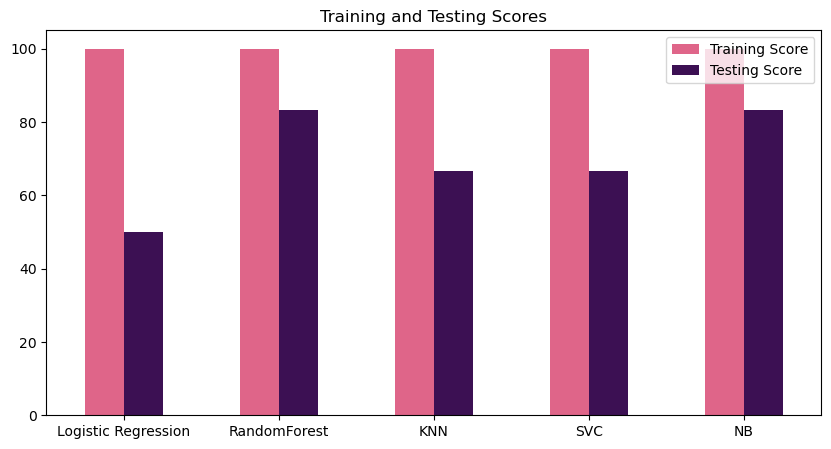

In [27]:
# Plot graph to compare models for Training and Testing Scores
trainScores = [lr_train_score_1, rf_train_score_1, knn_train_score_1, svc_train_score_1, nb_train_score_1]

testScores = [lr_test_score_1, rf_test_score_1, knn_test_score_1, svc_test_score_1, nb_test_score_1]

indices = ['Logistic Regression', 'RandomForest', 'KNN', 'SVC' , 'NB']

scores = pd.DataFrame({'Training Score': trainScores,'Testing Score': testScores}, index=indices)

plot = scores.plot.bar(figsize=(10, 5), rot=0, color=['#df6589ff', '#3c1053ff'])

plt.title('Training and Testing Scores')
plt.show()

In [28]:
# print scores dataframe created above 
scores.sort_values(by='Testing Score', ascending=False, inplace = True)
scores

,Training Score,Testing Score
RandomForest,100.0,83.333333
NB,100.0,83.333333
KNN,100.0,66.666667
SVC,100.0,66.666667
Logistic Regression,100.0,50.000000


Confusion Matrix

In [29]:
predVals = pd.DataFrame(data={'truth': Y_test, 
                              'Logisticregression': lr_pred_test, 
                              'RandomForest': rf_pred_test, 
                              'KNN': knn_pred_test, 
                              'SVC': svc_pred_test, 
                              'NaiveBayes': nb_pred_test})

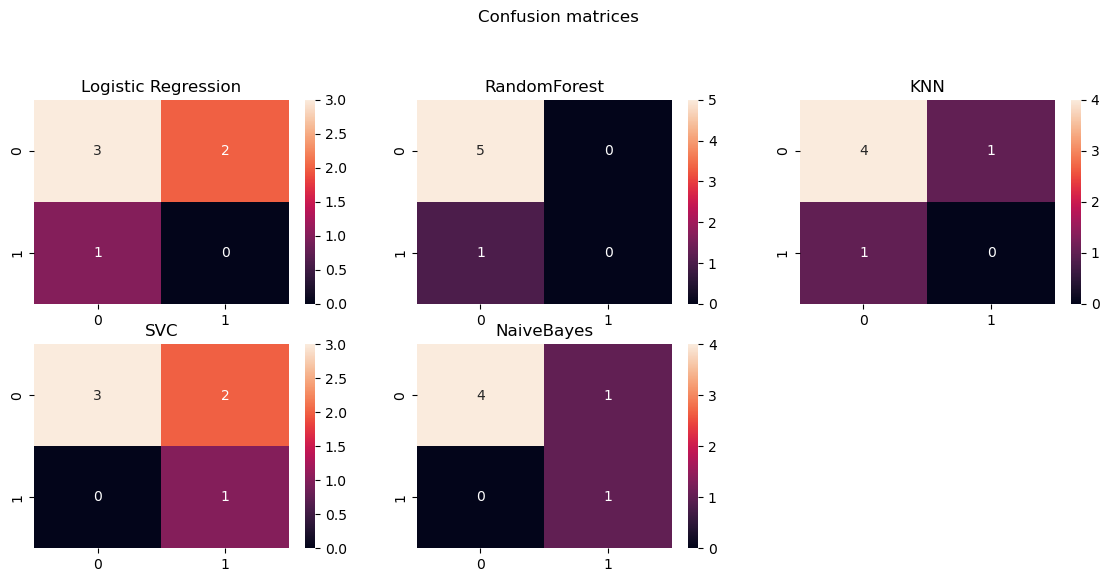

In [30]:
plt.figure(figsize=(14, 9))

plt.subplot(3, 3, 1)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, lr_pred_test), annot=True).set(title='Logistic Regression')

plt.subplot(3, 3, 2)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, rf_pred_test), annot=True).set(title='RandomForest')

plt.subplot(3, 3, 3)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, knn_pred_test), annot=True).set(title='KNN')

plt.subplot(3, 3, 4)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, svc_pred_test), annot=True).set(title='SVC')

plt.subplot(3, 3, 5)
sns.heatmap(sklearn.metrics.confusion_matrix(Y_test, nb_pred_test), annot=True).set(title='NaiveBayes')

plt.suptitle('Confusion matrices')
plt.show()

Classification reports

In [31]:
print("<< Logistic Regression >> \n\n", sklearn.metrics.classification_report(Y_test, lr_pred_test))

<< Logistic Regression >> 

               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.00      0.00      0.00         1

    accuracy                           0.50         6
   macro avg       0.38      0.30      0.33         6
weighted avg       0.62      0.50      0.56         6



In [32]:
print("<< Random Forest >>\n\n", sklearn.metrics.classification_report(Y_test, rf_pred_test))

<< Random Forest >>

               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.00      0.00      0.00         1

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
print("<< K Nearest Neighbour >>\n\n", sklearn.metrics.classification_report(Y_test, knn_pred_test))

<< K Nearest Neighbour >>

               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.00      0.00      0.00         1

    accuracy                           0.67         6
   macro avg       0.40      0.40      0.40         6
weighted avg       0.67      0.67      0.67         6



In [34]:
print("<< Supprt Vector >>\n\n", sklearn.metrics.classification_report(Y_test, svc_pred_test))

<< Supprt Vector >>

               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.33      1.00      0.50         1

    accuracy                           0.67         6
   macro avg       0.67      0.80      0.62         6
weighted avg       0.89      0.67      0.71         6



In [35]:
print("<< Naive Bayes >>\n\n", sklearn.metrics.classification_report(Y_test, nb_pred_test))

<< Naive Bayes >>

               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.50      1.00      0.67         1

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6



In [36]:
predVals.sample(6)

,truth,Logisticregression,RandomForest,KNN,SVC,NaiveBayes
10,1,0,0,0,1,1
3,0,0,0,0,0,0
4,0,1,0,0,1,1
6,0,0,0,0,0,0
7,0,0,0,0,0,0
2,0,1,0,1,1,0


now apply depp neural network on this to compare (ANN)
https://www.kaggle.com/datasets/primaryobjects/voicegender